In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
#Define the neural network model
# create_model() -Function to return a dictionary representing a neural network model.
#The dictionary has keys as Layer NAmes and values as the corresponding Dense Layers
def create_model():
  model = {
      'dense1': tf.keras.layers.Dense(50, activation='tanh'),
      'dense2': tf.keras.layers.Dense(50, activation='tanh'),
      'dense3': tf.keras.layers.Dense(50, activation='tanh'),
      'output_layer': tf.keras.layers.Dense(1)
  }
  return model

#call_model() - Function to define the forward pass of nn
#Takes as an input a dictionary model and an input tensor x

def call_model(model,x):
  x = model['dense1'](x)
  x = model['dense2'](x)
  x = model['dense3'](x)
  x = model['output_layer'](x)
  return x

#model = create_model()
#print(model)


In [3]:
#Define the differential equation using tf.GradientTape

def pde(x, model):
  with tf.GradientTape(persistent=True) as tape:
    tape.watch(x)
    y_pred = call_model(model,x)
    y_x = tape.gradient(y_pred, x)
  y_xx = tape.gradient(y_x, x)
  del tape
  return y_xx + np.pi**2*tf.sin(np.pi*x)


In [4]:
#Define the loss function
def loss(model, x, x_bc, y_bc):
  res = pde(x, model)

  #Mean Squared Error (MSE) of boundary conditions
  loss_pde = tf.reduce_mean(tf.square(res))
  y_bc_pred = call_model(model, x_bc)

  #Compute MSE for boundary conditions
  loss_bc = tf.reduce_mean(tf.square(y_bc - y_bc_pred))

  return loss_pde + loss_bc

In [5]:
# Define the training step
def train_step(model, x, x_bc, y_bc, optimizer):
  with tf.GradientTape() as tape:
    loss_value = loss(model, x, x_bc, y_bc)
  grads = tape.gradient(loss_value, [layer.trainable_variables for layer in model.values()])
  # Flatten the list of trainable variables
  grads = [grad for sublist in grads for grad in sublist]
  variables = [var for layer in model.values() for var in layer.trainable_variables]
  optimizer.apply_gradients(zip(grads, variables))
  return loss_value

In [6]:
# Setting up the problem

#Generating Training Data

x_train = np.linspace(-1, 1, 100).reshape(-1, 1)
x_train = tf.convert_to_tensor(x_train, dtype=tf.float32)

#Boundary data
x_bc = np.array([[-1.0], [1.0]], dtype = np.float32)
y_bc = np.array([[0.0], [0.0]], dtype = np.float32)
x_bc = tf.convert_to_tensor(x_bc, dtype = tf.float32)
y_bc = tf.convert_to_tensor(y_bc, dtype= tf.float32)

#The PINN model
model = create_model()

#Define the optimizer with a alearning rate scheduler
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate = 1e-3, decay_steps = 1000, decay_rate = 0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate = lr_schedule)

#Train the model
epochs = 2000
for epoch in range(epochs):
  loss_value = train_step(model, x_train, x_bc, y_bc, optimizer)
  if epoch % 200 == 0:
    print(f"Epoch {epoch}: Loss = {loss_value.numpy()}")



Epoch 0: Loss = 47.77312088012695
Epoch 200: Loss = 0.05035363510251045
Epoch 400: Loss = 0.004456519614905119
Epoch 600: Loss = 0.001083961222320795
Epoch 800: Loss = 0.0004749287327285856
Epoch 1000: Loss = 0.000329340691678226
Epoch 1200: Loss = 0.00022052868735045195
Epoch 1400: Loss = 0.00014825169637333602
Epoch 1600: Loss = 9.980668983189389e-05
Epoch 1800: Loss = 6.959094025660306e-05


In [7]:
# Predit the solution

x_test = np.linspace(-1, 1, 1000).reshape(-1, 1)
x_test = tf.convert_to_tensor(x_test, dtype=tf.float32)
y_pred = call_model(model, x_test).numpy()

# Analytical solution
y_true = np.sin(np.pi * x_test)


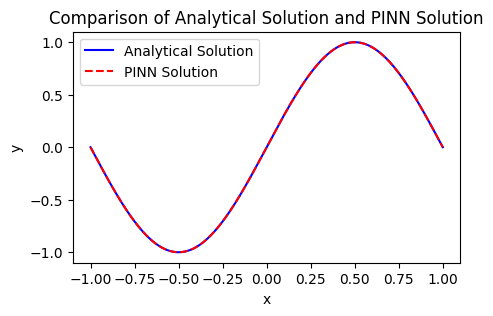

In [8]:
#Plot the results

plt.figure(figsize=(5,3))
plt.plot(x_test, y_true, 'b-', label = 'Analytical Solution')
plt.plot(x_test, y_pred, 'r--', label = 'PINN Solution')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Comparison of Analytical Solution and PINN Solution')
plt.show()